In [1]:
# %% Import packages
from pprint import pprint
from itertools import chain, compress, product
from functools import reduce, partial, lru_cache
from glob import iglob
from typing import Generator

from numba import jit
from yaml import safe_load
from cytoolz import compose, merge_with
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row, DataFrame, functions as f
from dltools import load_combiner
from dltools.sacla import restructure, load_analyzer

In [2]:
# %% Load PySpark
builder = (
    SparkSession
    .builder
    .config("spark.executor.memory", "4g")
    .config("spark.driver.memory", "4g")
    .config("spark.driver.maxResultSize", "2g")
    .config(        
        "spark.jars.packages",
        "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0,"
        "org.diana-hep:spark-root_2.11:0.1.15,"
    )
)

print("Loading PySpark...")
spark = builder.getOrCreate()
print("Done!")

Loading PySpark...
Done!


In [8]:
# %% Load data
from pyspark.sql.types import (
    ArrayType, BooleanType, LongType, StructField, StructType, DoubleType,
)
from dltools import SpkHits


print("Loading data...")
df = (
    spark
    .read
    .format("com.mongodb.spark.sql.DefaultSource")
    .option("uri", "mongodb://mongodb/sacla_2017b8065.resorted")
    .option("pipeline", """[
        {
            $match: {
                aq: {$in: [28, 29, 35, 36]},
            },
        },
        {
            $project: {
                tag: true,
                aq: true,
                gm1: true,
                gm2: true,
            },
        },
    ]""")
    .load()
)
df.printSchema()
print("Done!")

Loading data...
root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- aq: integer (nullable = true)
 |-- gm1: double (nullable = true)
 |-- gm2: double (nullable = true)
 |-- tag: long (nullable = true)

Done!


In [13]:
pdf = (
    df
    .select("tag", "aq", "gm1", "gm2")
    .toPandas()
    .sort_values("tag")
    .reindex())
pdf["gm1"] = pdf["gm1"].where(pdf["gm1"] > 0, np.nan)
pdf["gm2"] = pdf["gm2"].where(pdf["gm2"] > 0, np.nan)
pdf.head()

,tag,aq,gm1,gm2
227645,156993292,28,0.098236,0.017959
227646,156993293,28,0.084467,0.016943
227647,156993294,28,0.078348,0.015166
227648,156993295,28,0.096360,0.017418
227649,156993296,28,0.107663,0.019439


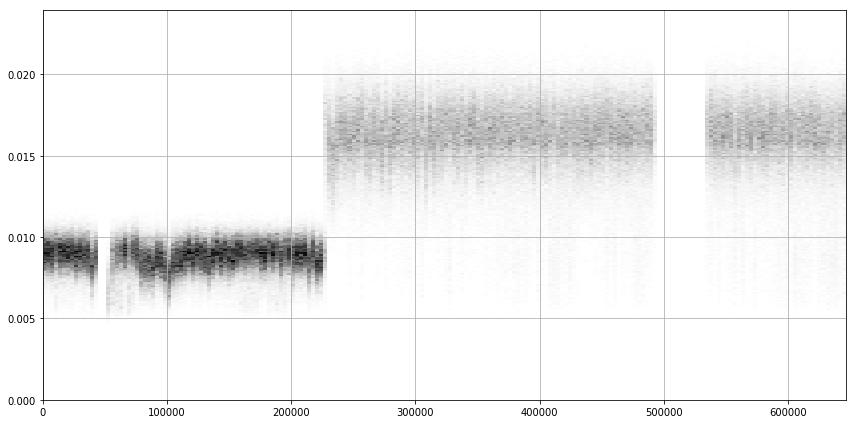

In [14]:
where = ~pdf.isna().any(1)

plt.figure(figsize=(12, 6))
plt.hist2d(pdf.index[where], pdf.loc[where, "gm2"], bins=(200, 200), cmap="Greys")
plt.ylim(0, None)
plt.grid(True)
plt.tight_layout()
plt.show()

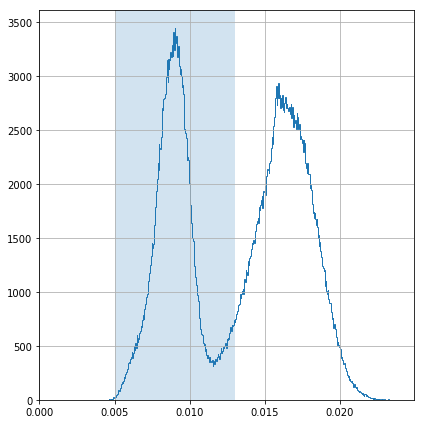

In [24]:
where = (
    ~pdf.isna().any(1)
    # & (pdf["aq"].isin([35, 36]))
)

plt.figure(figsize=(6, 6))
plt.hist(pdf.loc[where, "gm2"], bins=500, histtype="step")
plt.axvspan(0.005, 0.013, alpha=0.2)
plt.xlim(0, None)
plt.ylim(0, None)
plt.grid(True)
plt.tight_layout()
plt.show()

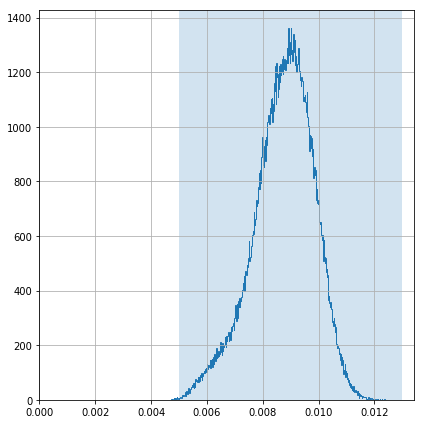

In [23]:
where = (
    ~pdf.isna().any(1)
    & (pdf["aq"].isin([35, 36]))
)

plt.figure(figsize=(6, 6))
plt.hist(pdf.loc[where, "gm2"], bins=500, histtype="step")
plt.axvspan(0.005, 0.013, alpha=0.2)
plt.xlim(0, None)
plt.ylim(0, None)
plt.grid(True)
plt.tight_layout()
plt.show()